##### Copyright 2020 The TensorFlow Authors.

In [59]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Simple audio recognition: Recognizing keywords

## Setup

Import necessary modules and dependencies.

In [60]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Importando categoria de sons

In [61]:

# data_dir = pathlib.Path('./dataset/normalized')
data_dir = pathlib.Path('./dataset/mono')

Check basic statistics about the dataset.

In [87]:
categories = np.array(tf.io.gfile.listdir(str(data_dir)))
print('Categorias:', categories)

Categorias: ['hihat' 'kick' 'noise' 'snare']


Extract the audio files into a list and shuffle it.

In [88]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/categories[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 272
Number of examples per label: 53
Example file tensor: tf.Tensor(b'dataset/mono/snare/MnSnA3Cpp2.wav', shape=(), dtype=string)


Divida os arquivos em conjuntos de treinamento, validação e teste usando uma proporção de 80:10:10, respectivamente.

In [89]:
import math

train_files_limit = math.trunc(num_samples * 0.8)
val_files_limit = math.trunc(num_samples * 0.1)
test_files_limit = math.trunc(num_samples * 0.1)

train_files = filenames[:train_files_limit]
val_files = filenames[train_files_limit: train_files_limit + val_files_limit]
test_files = filenames[-test_files_limit:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 217
Validation set size 27
Test set size 27


## Lendo arquivos de audio e categorias

O arquivo de áudio será inicialmente lido como um arquivo binário, que você desejará converter em um tensor numérico.

Para carregar um arquivo de áudio, você usará tf.audio.decode_wav, que retorna o áudio codificado em WAV como um Tensor e a taxa de amostragem.

Um arquivo WAV contém dados de séries temporais com um número definido de amostras por segundo. Cada amostra representa a amplitude do sinal de áudio naquele momento específico. Em um sistema de 16 bits, os valores variam de -32768 a 32767. A taxa de amostragem para este conjunto de dados é de 16kHz. Observe que tf.audio.decode_wav normalizará os valores para o intervalo [-1.0, 1.0].

In [90]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary, desired_channels=-1)
  return tf.squeeze(audio, axis=-1)

The label for each WAV file is its parent directory.

In [91]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2] 

Let's define a method that will take in the filename of the WAV file and output a tuple containing the audio and labels for supervised training.

In [92]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

You will now apply `process_path` to build your training set to extract the audio-label pairs and check the results. You'll build the validation and test sets using a similar procedure later on.

In [93]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

Let's examine a few audio waveforms with their corresponding labels.

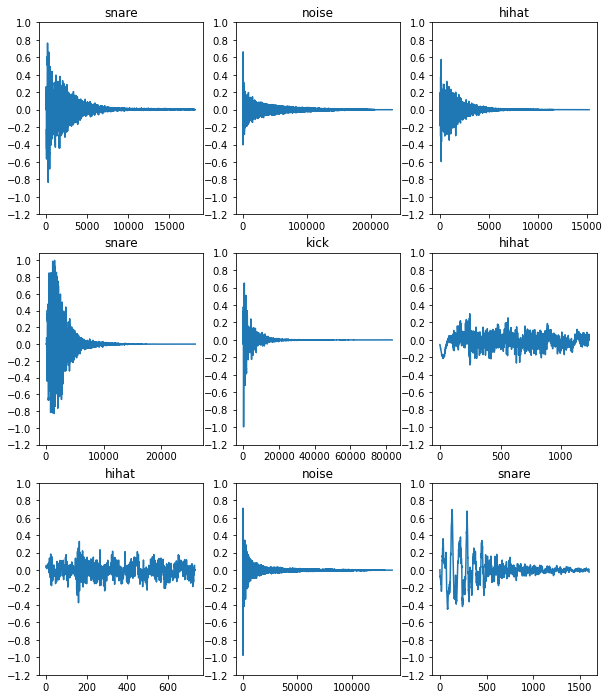

In [94]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

## Spectrogram

You'll convert the waveform into a spectrogram, which shows frequency changes over time and can be represented as a 2D image. This can be done by applying the short-time Fourier transform (STFT) to convert the audio into the time-frequency domain.

A Fourier transform ([`tf.signal.fft`](https://www.tensorflow.org/api_docs/python/tf/signal/fft)) converts a signal to its component frequencies, but loses all time information. The STFT ([`tf.signal.stft`](https://www.tensorflow.org/api_docs/python/tf/signal/stft)) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

STFT produces an array of complex numbers representing magnitude and phase. However, you'll only need the magnitude for this tutorial, which can be derived by applying `tf.abs` on the output of `tf.signal.stft`. 

Choose `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on STFT parameters choice, you can refer to [this video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing. 

You also want the waveforms to have the same length, so that when you convert it to a spectrogram image, the results will have similar dimensions. This can be done by simply zero padding the audio clips that are shorter than one second.


In [95]:
sample_size = 1500
def get_spectrogram(waveform):
  # Padding for files with less than 3000 samples
  if [sample_size] - tf.shape(waveform) > 0:
    zero_padding = tf.zeros([sample_size] - tf.shape(waveform), dtype=tf.float32)
  else:
    zero_padding = tf.zeros(0, dtype=tf.float32)
    
  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform[0:sample_size], zero_padding], 0)
  spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram

Next, you will explore the data. Compare the waveform, the spectrogram and the actual audio of one example from the dataset.

In [96]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: snare
Waveform shape: (18128,)
Spectrogram shape: (10, 129)
Audio playback


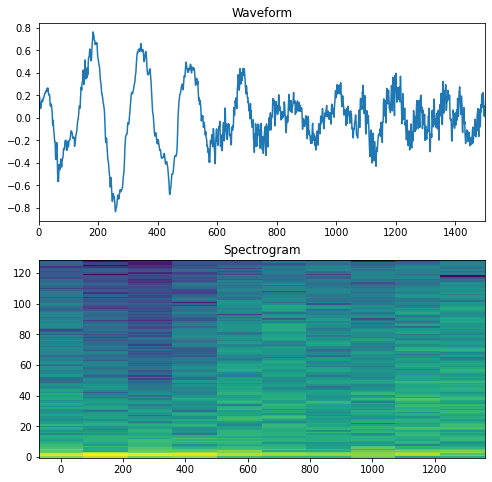

In [97]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(8, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, sample_size])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

Now transform the waveform dataset to have spectrogram images and their corresponding labels as integer IDs.

In [98]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == categories)
  return spectrogram, label_id

In [99]:
spectrogram_ds = waveform_ds.map(get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

Examine the spectrogram "images" for different samples of the dataset.

/tmp/ipykernel_30/1328264651.py:4: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


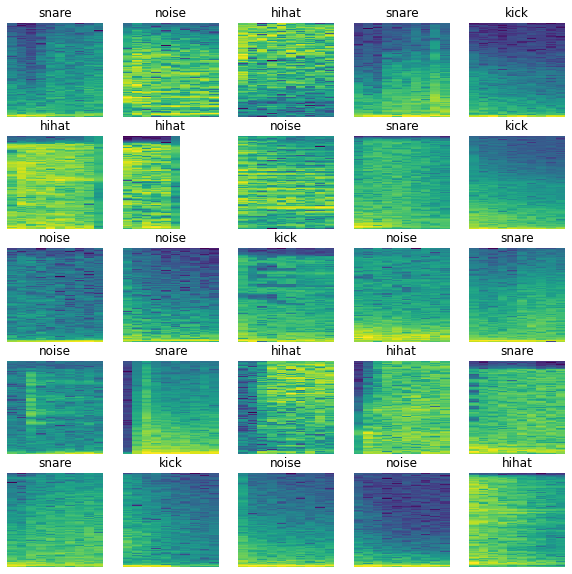

In [100]:
rows = 5
cols = 5
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(categories[label_id.numpy()])
  ax.axis('off')
  
plt.show()

## Build and train the model

Now you can build and train your model. But before you do that, you'll need to repeat the training set preprocessing on the validation and test sets.

In [101]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [102]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Batch the training and validation sets for model training.

In [103]:
batch_size = 10
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Add dataset [`cache()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) and [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) operations to reduce read latency while training the model.

In [104]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.
The model also has the following additional preprocessing layers:
- A [`Resizing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer to downsample the input to enable the model to train faster.
- A [`Normalization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Normalization) layer to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (i.e. mean and standard deviation).

In [105]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(categories)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (10, 129, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_2 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)        

In [106]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [107]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

model.save(filepath='./model')

Epoch 1/10
22/22 [==============================] - 1s 27ms/step - loss: 1.0500 - accuracy: 0.5253 - val_loss: 0.7976 - val_accuracy: 0.6667
Epoch 2/10
22/22 [==============================] - 0s 20ms/step - loss: 0.7688 - accuracy: 0.7005 - val_loss: 0.6796 - val_accuracy: 0.7778
Epoch 3/10
22/22 [==============================] - 0s 19ms/step - loss: 0.6861 - accuracy: 0.7604 - val_loss: 0.5522 - val_accuracy: 0.8519
Epoch 4/10
22/22 [==============================] - 0s 19ms/step - loss: 0.6501 - accuracy: 0.7696 - val_loss: 0.4939 - val_accuracy: 0.8519
Epoch 5/10
22/22 [==============================] - 0s 19ms/step - loss: 0.4168 - accuracy: 0.8525 - val_loss: 0.4599 - val_accuracy: 0.8889
Epoch 6/10
22/22 [==============================] - 0s 20ms/step - loss: 0.2942 - accuracy: 0.8894 - val_loss: 0.4537 - val_accuracy: 0.8889
Epoch 7/10
22/22 [==============================] - 0s 19ms/step - loss: 0.3470 - accuracy: 0.8664 - val_loss: 0.4183 - val_accuracy: 0.8889
Epoch 8/10
22

Let's check the training and validation loss curves to see how your model has improved during training.

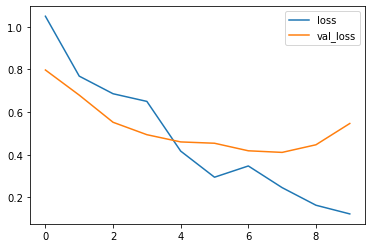

In [108]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

## Evaluate test set performance

Let's run the model on the test set and check performance.

In [109]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [110]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 93%


### Exibir uma matriz de confusão

Uma matriz de confusão é útil para ver o desempenho do modelo em cada um dos comandos do conjunto de teste.

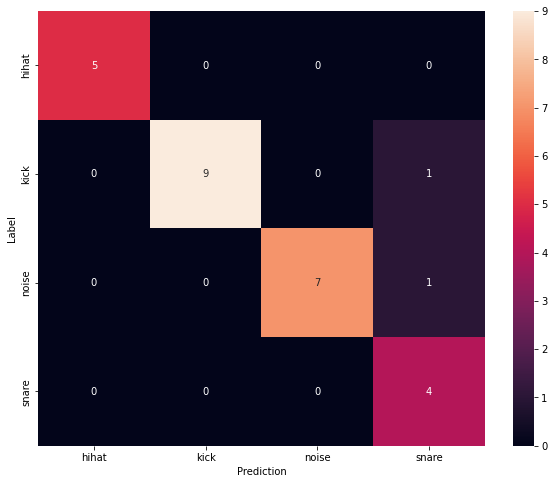

In [111]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=categories, yticklabels=categories, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no." How well does your model perform?

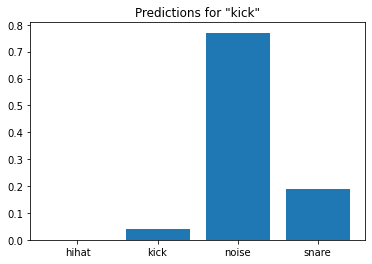

In [113]:
data_test_dir = pathlib.Path('./dataset/test')
sample_file = data_test_dir/'kick/kick001.wav'
# sample_file = data_test_dir/'snare/snare001.wav'
# sample_file = data_test_dir/'hihat/hihat001.wav'
# sample_file = data_test_dir/'noise/noise002.wav'

sample_ds = preprocess_dataset([str(sample_file)])
for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(categories, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{categories[label[0]]}"')
  plt.show()

## Next steps

This tutorial showed how you could do simple audio classification using a convolutional neural network with TensorFlow and Python.

* To learn how to use transfer learning for audio classification, check out the [Sound classification with YAMNet](https://www.tensorflow.org/hub/tutorials/yamnet) tutorial.

* To build your own interactive web app for audio classification, consider taking the [TensorFlow.js - Audio recognition using transfer learning codelab](https://codelabs.developers.google.com/codelabs/tensorflowjs-audio-codelab/index.html#0).

* TensorFlow also has additional support for [audio data preparation and augmentation](https://www.tensorflow.org/io/tutorials/audio) to help with your own audio-based projects.
